In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# RetinaNet

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KBALF6O7uSsO4ZWszj5o")
project = rf.workspace("pani-edukal").project("ev-priority-classified-dataset-yxqyu")
version = project.version(2)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 39.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 98.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-sto


Extracting Dataset Version Zip to EV-Priority-Classified-Dataset-2 in coco:: 100%|██████████| 1640/1640 [00:00<00:00, 5628.16it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Epoch 1/20
------------------------------
Loss: 0.7018 | Acc: 0.8458 | P: 0.8314 | R: 0.8458 | F1: 0.8353

Epoch 2/20
------------------------------
Loss: 0.3456 | Acc: 0.8856 | P: 0.8912 | R: 0.8856 | F1: 0.8799

Epoch 3/20
------------------------------
Loss: 0.2893 | Acc: 0.8756 | P: 0.8578 | R: 0.8756 | F1: 0.8628

Epoch 4/20
------------------------------
Loss: 0.2026 | Acc: 0.8657 | P: 0.8608 | R: 0.8657 | F1: 0.8608

Epoch 5/20
------------------------------
Loss: 0.1671 | Acc: 0.9005 | P: 0.8952 | R: 0.9005 | F1: 0.8970

Epoch 6/20
------------------------------
Loss: 0.1610 | Acc: 0.8706 | P: 0.8833 | R: 0.8706 | F1: 0.8660

Epoch 7/20
------------------------------
Loss: 0.1215 | Acc: 0.8806 | P: 0.8842 | R: 0.8806 | F1: 0.8782

Epoch 8/20
------------------------------
Loss: 0.1270 | Acc: 0.8955 | P: 0.8904 | R

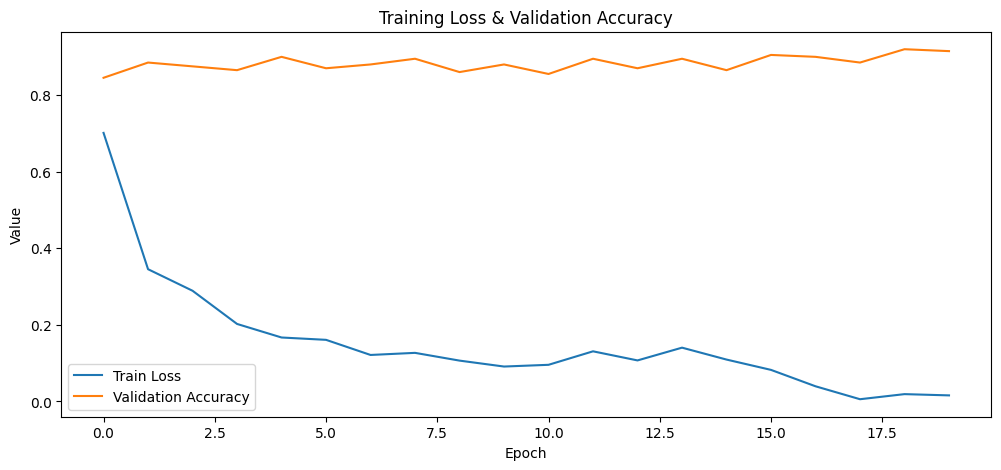

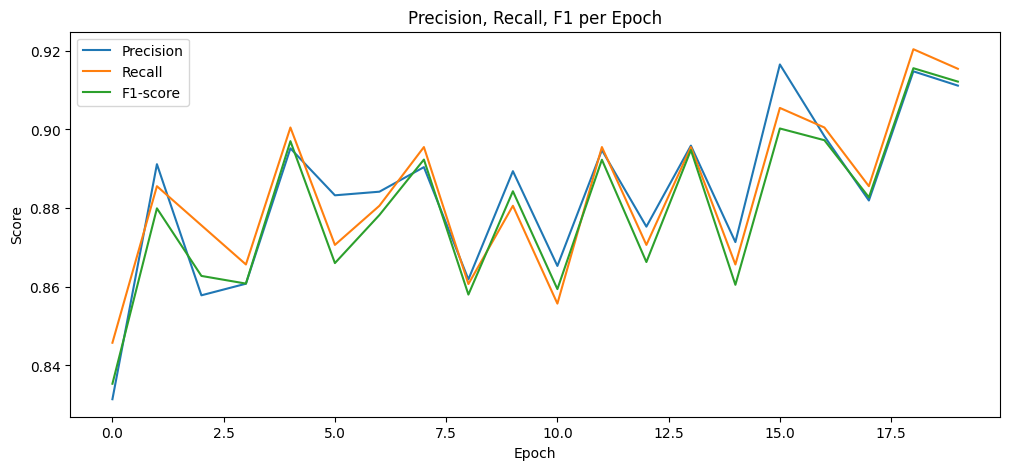

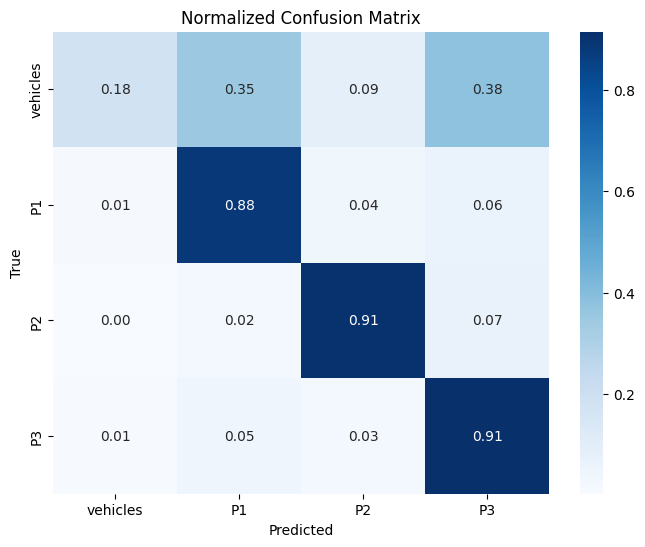

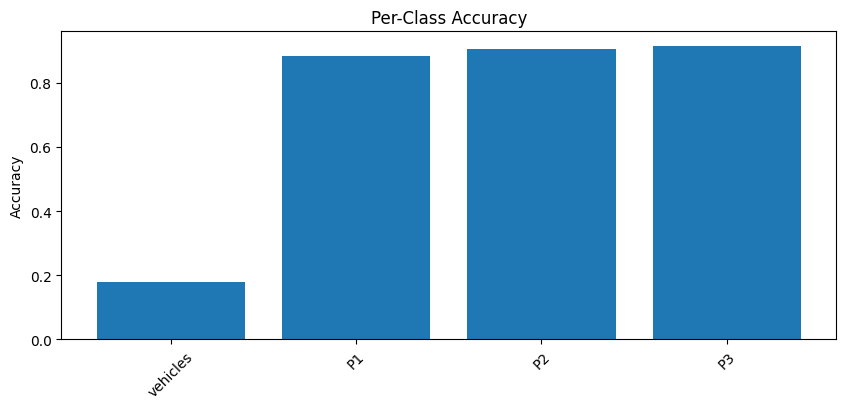

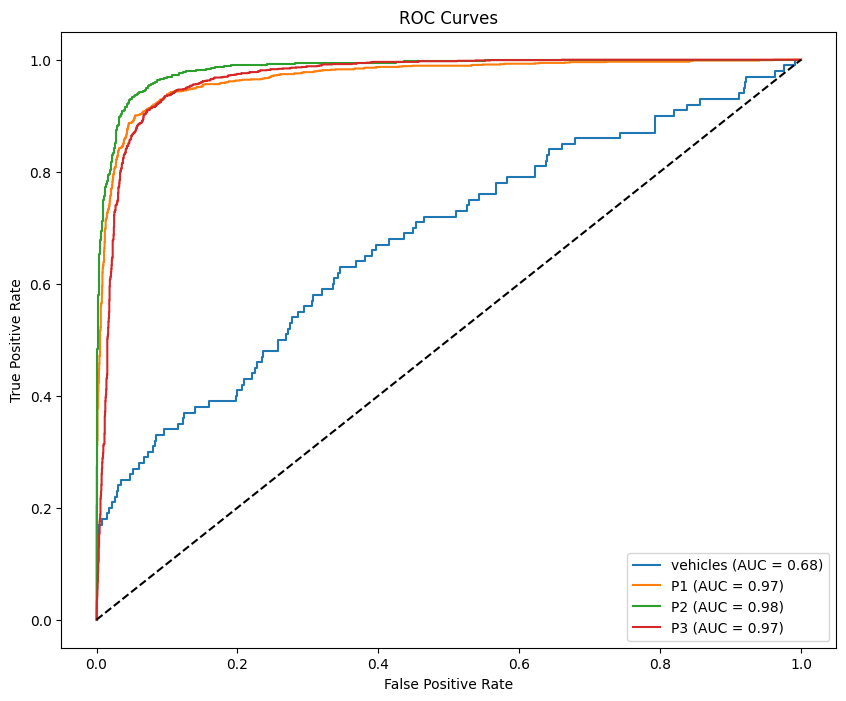

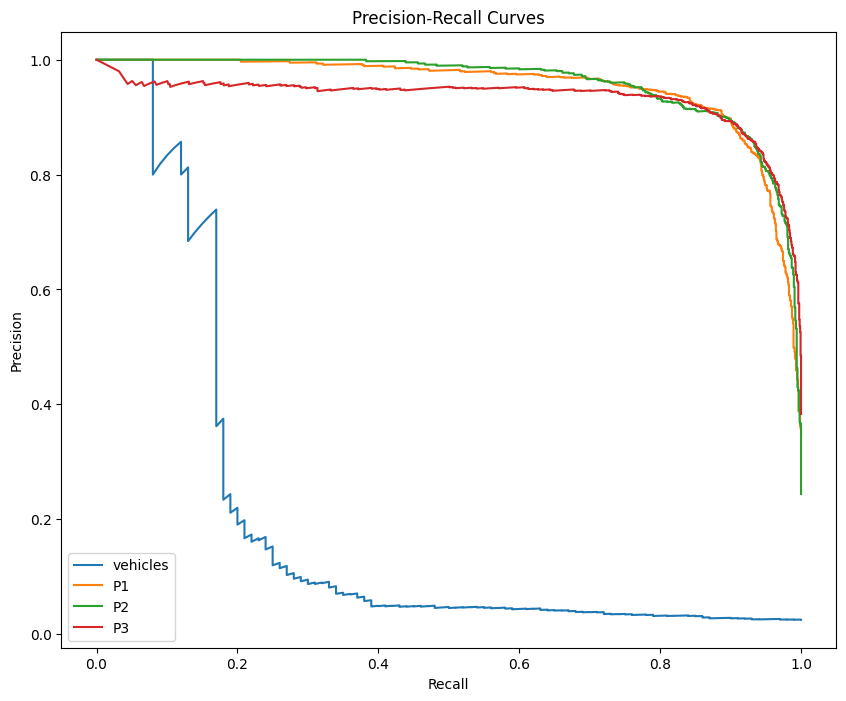

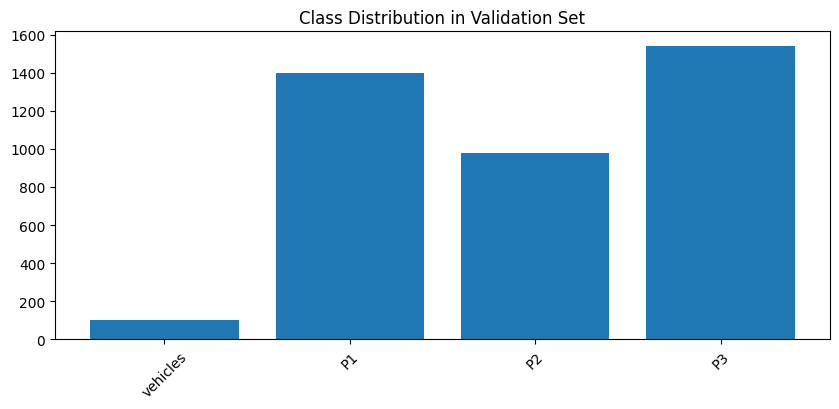

Top-3 Accuracy: 0.986318407960199
Per-class AP: [0.20301500656072274, 0.9538755343682251, 0.9601623619180423, 0.9330490461322748]
mAP@[.50:.95] (classification adaptation): 0.7625254872448163


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    average_precision_score, roc_curve, auc, precision_recall_curve
)
import numpy as np
from torchvision.datasets import CocoDetection
import json
from PIL import Image
from sklearn.preprocessing import label_binarize

# ---------------- Backbone (ResNet50 + FPN) ----------------
class BackboneWithFPN(nn.Module):
    def __init__(self):
        super().__init__()
        backbone = torchvision.models.resnet50(weights='IMAGENET1K_V1')
        self.stage1 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu, backbone.maxpool, backbone.layer1)
        self.stage2 = backbone.layer2
        self.stage3 = backbone.layer3
        self.stage4 = backbone.layer4

        self.lateral4 = nn.Conv2d(2048, 256, 1)
        self.lateral3 = nn.Conv2d(1024, 256, 1)
        self.lateral2 = nn.Conv2d(512, 256, 1)
        self.lateral1 = nn.Conv2d(256, 256, 1)

        self.smooth3 = nn.Conv2d(256, 256, 3, padding=1)
        self.smooth2 = nn.Conv2d(256, 256, 3, padding=1)
        self.smooth1 = nn.Conv2d(256, 256, 3, padding=1)

    def forward(self, x):
        c1 = self.stage1(x)
        c2 = self.stage2(c1)
        c3 = self.stage3(c2)
        c4 = self.stage4(c3)

        p4 = self.lateral4(c4)
        p3 = self.lateral3(c3) + F.interpolate(p4, scale_factor=2, mode="nearest")
        p2 = self.lateral2(c2) + F.interpolate(p3, scale_factor=2, mode="nearest")
        p1 = self.lateral1(c1) + F.interpolate(p2, scale_factor=2, mode="nearest")

        p3 = self.smooth3(p3)
        p2 = self.smooth2(p2)
        p1 = self.smooth1(p1)

        return [p1, p2, p3, p4]

# ---------------- RetinaNet-based Classifier ----------------
class RetinaNetClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.backbone = BackboneWithFPN()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        features = self.backbone(x)
        x = features[0]  # highest resolution FPN feature
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# ---------------- Custom COCO Dataset Wrapper ----------------
class CocoClassification(CocoDetection):
    def __init__(self, img_folder, ann_file, transform=None):
        super().__init__(img_folder, ann_file, transform)
        with open(ann_file, "r") as f:
            data = json.load(f)
        cats = data["categories"]
        self.classes = [c["name"] for c in sorted(cats, key=lambda x: x["id"])]
        self.num_classes = len(self.classes)
        self.cat_id_to_class_idx = {c["id"]: idx for idx, c in enumerate(cats)}

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)
        if len(target) == 0:
            label = 0
        else:
            cat_id = target[0]["category_id"]
            label = self.cat_id_to_class_idx[cat_id]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# ---------------- Training ----------------
# def train_model(model, train_loader, val_loader, device, num_epochs=50, lr=1e-4):
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     train_losses, val_accs = [], []
#     precisions, recalls, f1s = [], [], []
#     all_labels, all_preds, all_probs = [], [], []

#     for epoch in range(num_epochs):
#         print(f"\nEpoch {epoch+1}/{num_epochs}")
#         print("-"*30)

#         # Training
#         model.train()
#         running_loss = 0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()

#         epoch_loss = running_loss / len(train_loader)
#         train_losses.append(epoch_loss)

#         # Validation
#         model.eval()
#         correct, total = 0, 0
#         y_true, y_pred, y_probs = [], [], []
#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 probs = torch.softmax(outputs, dim=1)
#                 _, predicted = torch.max(outputs, 1)

#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#                 y_true.extend(labels.cpu().numpy())
#                 y_pred.extend(predicted.cpu().numpy())
#                 y_probs.extend(probs.cpu().numpy())

#         acc = correct / total
#         val_accs.append(acc)

#         precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
#         recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
#         f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

#         precisions.append(precision)
#         recalls.append(recall)
#         f1s.append(f1)

#         all_labels.extend(y_true)
#         all_preds.extend(y_pred)
#         all_probs.extend(y_probs)

#         print(f"Loss: {epoch_loss:.4f} | Acc: {acc:.4f} | P: {precision:.4f} | R: {recall:.4f} | F1: {f1:.4f}")

#     return train_losses, val_accs, precisions, recalls, f1s, all_labels, all_preds, np.array(all_probs)
# ---------------- Training with Early Stopping ----------------
def train_model(model, train_loader, val_loader, device, num_epochs=50, lr=1e-4, acc_threshold=0.9, patience=3):
    """
    acc_threshold : stop checking once validation accuracy reaches this
    patience : number of epochs to wait after accuracy drops before stopping
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_accs = [], []
    precisions, recalls, f1s = [], [], []
    all_labels, all_preds, all_probs = [], [], []

    best_acc = 0
    epochs_since_improvement = 0
    early_stop_triggered = False

    for epoch in range(num_epochs):
        if early_stop_triggered:
            print("Early stopping triggered. Stopping training.")
            break

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-"*30)

        # Training
        model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        y_true, y_pred, y_probs = [], [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
                y_probs.extend(probs.cpu().numpy())

        acc = correct / total
        val_accs.append(acc)

        precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

        all_labels.extend(y_true)
        all_preds.extend(y_pred)
        all_probs.extend(y_probs)

        print(f"Loss: {epoch_loss:.4f} | Acc: {acc:.4f} | P: {precision:.4f} | R: {recall:.4f} | F1: {f1:.4f}")

        # Early stopping check
        if acc > acc_threshold:
            if acc > best_acc:
                best_acc = acc
                epochs_since_improvement = 0
            else:
                epochs_since_improvement += 1
                if epochs_since_improvement >= patience:
                    early_stop_triggered = True

    return train_losses, val_accs, precisions, recalls, f1s, all_labels, all_preds, np.array(all_probs)

# ---------------- Main ----------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    train_dataset = CocoClassification(
        img_folder="/kaggle/working/EV-Priority-Classified-Dataset-2/train",
        ann_file="/kaggle/working/EV-Priority-Classified-Dataset-2/train/_annotations.coco.json",
        transform=transform
    )

    test_dataset = CocoClassification(
        img_folder="/kaggle/working/EV-Priority-Classified-Dataset-2/test",
        ann_file="/kaggle/working/EV-Priority-Classified-Dataset-2/test/_annotations.coco.json",
        transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    model = RetinaNetClassifier(num_classes=train_dataset.num_classes).to(device)

    train_losses, val_accs, precisions, recalls, f1s, all_labels, all_preds, all_probs = train_model(
        model, train_loader, val_loader, device, num_epochs=20, lr=1e-4
    )

    # ---------------- Plot Metrics ----------------
    # Loss & Accuracy
    plt.figure(figsize=(12,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.title("Training Loss & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # Precision, Recall, F1
    plt.figure(figsize=(12,5))
    plt.plot(precisions, label="Precision")
    plt.plot(recalls, label="Recall")
    plt.plot(f1s, label="F1-score")
    plt.title("Precision, Recall, F1 per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

    # Confusion Matrix (Normalized)
    cm = confusion_matrix(all_labels, all_preds)
    cm_norm = confusion_matrix(all_labels, all_preds, normalize='true')
    plt.figure(figsize=(8,6))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=train_dataset.classes,
                yticklabels=train_dataset.classes)
    plt.title("Normalized Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Per-Class Accuracy
    per_class_acc = {}
    for i, class_name in enumerate(train_dataset.classes):
        idxs = [j for j, label in enumerate(all_labels) if label == i]
        correct = sum([all_preds[j] == i for j in idxs])
        per_class_acc[class_name] = correct / max(1, len(idxs))

    plt.figure(figsize=(10,4))
    plt.bar(per_class_acc.keys(), per_class_acc.values())
    plt.title("Per-Class Accuracy")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=45)
    plt.show()

    # ROC Curves & AUC
    y_true_bin = label_binarize(all_labels, classes=list(range(train_dataset.num_classes)))
    plt.figure(figsize=(10,8))
    for i in range(train_dataset.num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{train_dataset.classes[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curves
    plt.figure(figsize=(10,8))
    for i in range(train_dataset.num_classes):
        y_true_bin_i = y_true_bin[:, i]
        precision, recall, _ = precision_recall_curve(y_true_bin_i, all_probs[:, i])
        plt.plot(recall, precision, label=train_dataset.classes[i])
    plt.title("Precision-Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    # Class Distribution in Validation Set
    labels_count = [0]*train_dataset.num_classes
    for l in all_labels:
        labels_count[l] += 1
    plt.figure(figsize=(10,4))
    plt.bar(train_dataset.classes, labels_count)
    plt.title("Class Distribution in Validation Set")
    plt.xticks(rotation=45)
    plt.show()

    # Top-K Accuracy
    def top_k_accuracy(all_labels, all_probs, k=3):
        topk_preds = np.argsort(all_probs, axis=1)[:, -k:]
        correct = sum([all_labels[i] in topk_preds[i] for i in range(len(all_labels))])
        return correct / len(all_labels)

    print("Top-3 Accuracy:", top_k_accuracy(all_labels, all_probs, k=3))

    # Per-class AP & mAP
    aps = []
    for i in range(train_dataset.num_classes):
        y_true_bin_i = np.array([1 if y==i else 0 for y in all_labels])
        y_scores = all_probs[:, i]
        if y_true_bin_i.sum() > 0:
            aps.append(average_precision_score(y_true_bin_i, y_scores))
        else:
            aps.append(0)
    map50_95 = np.mean(aps)
    print("Per-class AP:", aps)
    print("mAP@[.50:.95] (classification adaptation):", map50_95)


In [11]:
# ---------------- Save Full Model ----------------
model_path = "/kaggle/working/retinanet_final.pth"
torch.save(model, model_path)
print(f"Full model saved to {model_path}")


Full model saved to /kaggle/working/retinanet_final.pth


################################